In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az

df = pd.read_csv('/content/drive/MyDrive/ABDA/matches.csv')

/tmp/ipython-input-3994045309.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/ABDA/matches.csv')


In [2]:

# 1. Create Team Indices
# We pool all unique teams from both home and away columns
all_teams = pd.unique(df[['home_team_id', 'away_team_id']].values.ravel())
team_map = {team: i for i, team in enumerate(all_teams)}
num_teams = len(all_teams)

# 2. Create Season Indices (Temporal Index)
# Map years (1888-2023) to 0-135
seasons = sorted(df['season'].unique())
season_map = {year: i for i, year in enumerate(seasons)}
num_seasons = len(seasons)

# 3. Map the dataframe
df['home_idx'] = df['home_team_id'].map(team_map).values.astype("int64")
df['away_idx'] = df['away_team_id'].map(team_map).values.astype("int64")
df['season_idx'] = df['season'].map(season_map).values.astype("int64")

df['home_idx'] = df['home_idx'].astype("int64")
df['away_idx'] = df['away_idx'].astype("int64")
df['season_idx'] = df['season_idx'].astype("int64")

# Target variable: Home Team Margin
y = df['home_team_score_margin'].values

In [3]:
df['season'].unique()

array([1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898,
       1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909,
       1910, 1911, 1912, 1913, 1914, 1919, 1920, 1921, 1922, 1923, 1924,
       1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935,
       1936, 1937, 1938, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953,
       1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964,
       1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975,
       1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986,
       1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
       1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020, 2021, 2022, 2023])

In [4]:
with pm.Model() as model_rq1:
    # --- DATA INPUTS ---
    # home_idx = pm.Data("home_idx", df['home_idx'])
    # away_idx = pm.Data("away_idx", df['away_idx'])
    # season_idx = pm.Data("season_idx", df['season_idx'])
    # Run this before defining the model
    home_idx = df['home_idx'].values.astype("int64")
    away_idx = df['away_idx'].values.astype("int64")
    season_idx = df['season_idx'].values.astype("int64")



    # --- HYPER-PRIORS (Level 3) ---
    sigma_u = pm.Exponential("sigma_u", 1.0)        # Spread of team abilities
    sigma_drift = pm.Exponential("sigma_drift", 1.0) # Speed of HA evolution
    sigma_delta = pm.Exponential("sigma_delta", 1.0) # Spread of team HA offsets

    # --- GROUP-LEVEL PRIORS (Level 2) ---

    # 1. Team Latent Ability (u)
    # Mean-centered at 0
    # u = pm.Normal("u", mu=0, sigma=sigma_u, shape=num_teams)

    u_offset = pm.Normal("u_offset", mu=0, sigma=1, shape=num_teams)
    u = pm.Deterministic("u", u_offset * sigma_u)

    # 2. Temporal Home Advantage (h_t) - THE EVOLUTION
    # We use a Random Walk so that Season T depends on Season T-1
    ha_temporal = pm.GaussianRandomWalk("ha_temporal",
                                        sigma=sigma_drift,
                                        shape=num_seasons)



    delta_offset = pm.Normal("delta_offset", mu=0, sigma=1, shape=num_teams)
    ha_team_offset = pm.Deterministic("ha_team_offset", delta_offset * sigma_delta)

    # 3. Team-Specific HA Offset (delta) - THE "delta" EFFECT
    # Professor's suggested "Random Slopes"
    # ha_team_offset = pm.Normal("ha_team_offset", mu=0, sigma=sigma_delta, shape=num_teams)

    # --- DATA MODEL / LIKELIHOOD (Level 1) ---

    # Linear Predictor: (Home Ability - Away Ability) + Temporal HA + Team HA Offset
    mu = (u[home_idx] - u[away_idx]) + \
         ha_temporal[season_idx] + \
         ha_team_offset[home_idx]

    # Standard deviation of the match margin noise
    eps = pm.HalfNormal("eps", sigma=2.0)

    # Likelihood
    margin = pm.Normal("margin", mu=mu, sigma=eps, observed=y)

    # --- SAMPLING ---
    # Using 2000 samples for the posterior
    trace = pm.sample(1000, tune=1000, return_inferencedata=True,
        idata_kwargs={"log_likelihood": True},
                      chains = 2,target_accept=0.9)

/usr/local/lib/python3.12/dist-packages/pymc/distributions/timeseries.py:291: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


In [9]:
import arviz as az

# trace = az.from_netcdf("/content/drive/MyDrive/ABDA/trace_rq122.nc")
# trace2 = az.from_netcdf("/content/drive/MyDrive/ABDA/trace_betaslope11feb.nc")

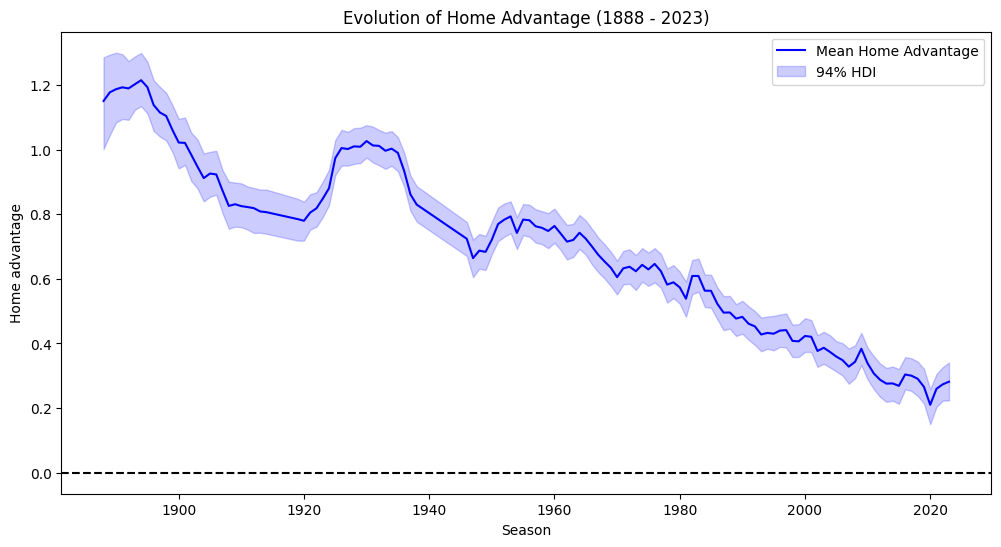

In [10]:

import matplotlib.pyplot as plt

# Extract the posterior mean for the temporal effect
post_ha = trace.posterior["ha_temporal"].mean(dim=["chain", "draw"])
hdi_ha = az.hdi(trace).ha_temporal # Highest Density Interval (Uncertainty)

plt.figure(figsize=(12, 6))
plt.plot(seasons, post_ha, label="Mean Home Advantage", color="blue")
plt.fill_between(seasons, hdi_ha[:, 0], hdi_ha[:, 1], color="blue", alpha=0.2, label="94% HDI")

plt.axhline(0, color="black", linestyle="--")
plt.title("Evolution of Home Advantage (1888 - 2023)")
plt.xlabel("Season")
plt.ylabel("Home advantage")
plt.legend()
plt.show()

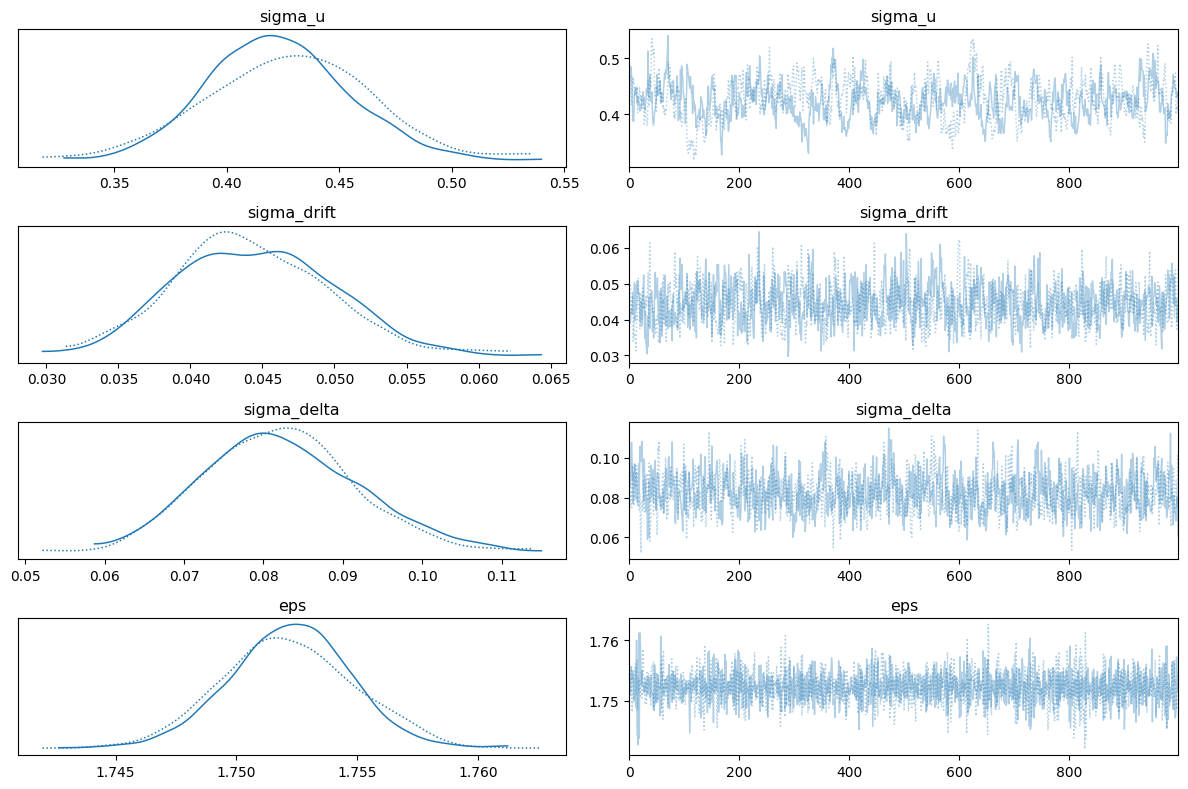

In [11]:
# Usually, we plot just the hyper-priors first so the screen isn't crowded
az.plot_trace(trace, var_names=["sigma_u", "sigma_drift", "sigma_delta", "eps",])


plt.tight_layout()

In [ ]:
summary_all_vars = az.summary(trace, var_names=var_names_to_plot, coords=coords_to_plot)
print(summary_all_vars)

                   mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma_u           0.395  0.026   0.350    0.443      0.002    0.001     125.0   
sigma_drift       0.044  0.005   0.034    0.054      0.000    0.000     646.0   
sigma_delta       0.070  0.008   0.055    0.086      0.000    0.000    1017.0   
eps               1.756  0.003   1.750    1.761      0.000    0.000    4579.0   
u[4]              0.287  0.046   0.208    0.379      0.003    0.001     216.0   
ha_temporal[110]  0.380  0.029   0.325    0.431      0.001    0.001    1751.0   

                  ess_tail  r_hat  
sigma_u              469.0   1.02  
sigma_drift          842.0   1.00  
sigma_delta         1352.0   1.00  
eps                 1417.0   1.00  
u[4]                 614.0   1.01  
ha_temporal[110]    1094.0   1.00  


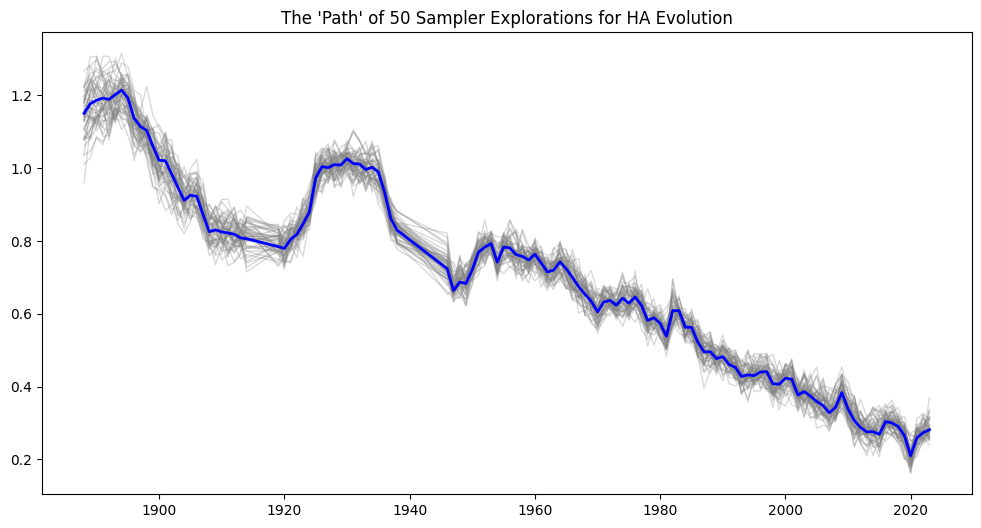

In [14]:
# Extract the first 50 paths (draws) from the first chain
ha_samples = trace.posterior["ha_temporal"].values[0, :50, :]

plt.figure(figsize=(12, 6))
for i in range(50):
    plt.plot(seasons, ha_samples[i, :], color="gray", alpha=0.3, lw=1)

# Overlay the mean (the 'final' answer)
plt.plot(seasons, post_ha, color="blue", lw=2, label="Posterior Mean")
plt.title("The 'Path' of 50 Sampler Explorations for HA Evolution")
plt.show()

array([[<Axes: title={'center': 'ha_temporal'}>,
        <Axes: title={'center': 'ha_temporal'}>]], dtype=object)

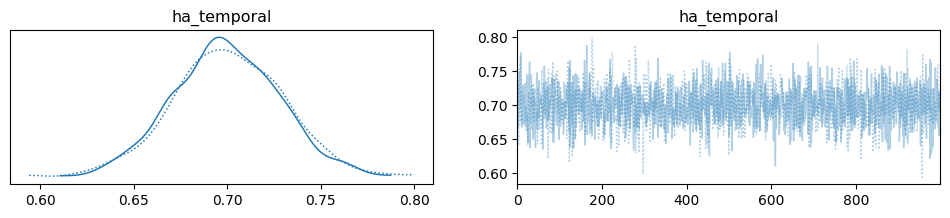

In [15]:
# Look at the path for the index corresponding to 1966
year_idx = seasons.index(1966)
az.plot_trace(trace, var_names=["ha_temporal"], coords={"ha_temporal_dim_0": [year_idx]})

In [19]:
import numpy as np

# 1. Get the predicted means (posterior predictive)
# (If you haven't run sample_posterior_predictive, do that first)
ppc = pm.sample_posterior_predictive(trace, model=model_rq1)

# 2. Calculate RMSE for Home Goals
home_pred = ppc.posterior_predictive["margin"].mean(dim=["chain", "draw"])
rmse_home = np.sqrt(np.mean((y - home_pred)**2))

# print(f"Average error in home goals: {rmse_home:.3f}")
# az.plot_ppc(ppc, kind="kde")

Output()

Average error in home goals: 1.755


<Axes: xlabel='margin'>

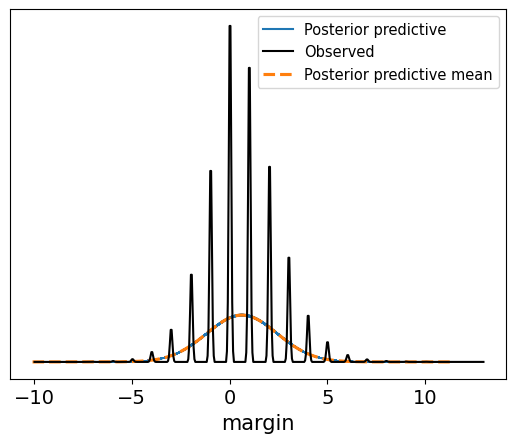

In [ ]:
print(f"Average error in home goals: {rmse_home:.3f}")
az.plot_ppc(ppc, kind="kde")

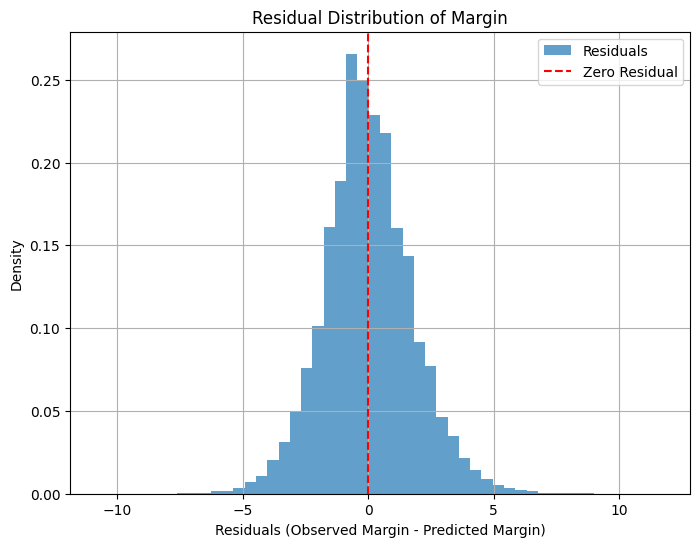

In [20]:
residuals = y - home_pred

plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=50, density=True, alpha=0.7, label='Residuals')
plt.title('Residual Distribution of Margin')
plt.xlabel('Residuals (Observed Margin - Predicted Margin)')
plt.ylabel('Density')
plt.axvline(0, color='red', linestyle='--', label='Zero Residual')
plt.legend()
plt.grid(True)
plt.show()


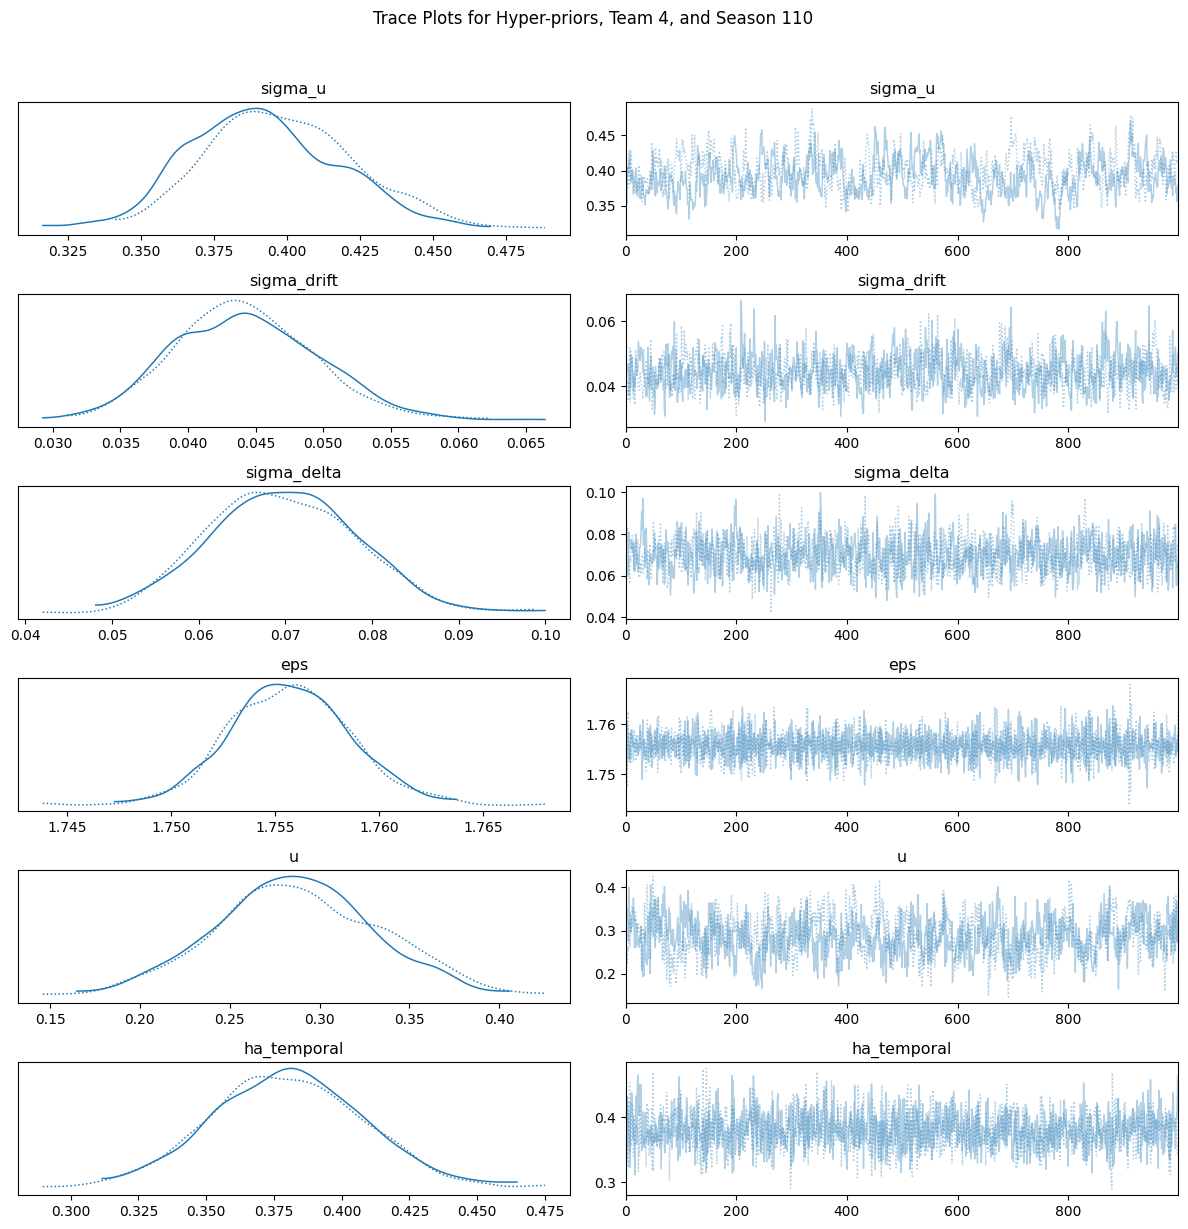

In [ ]:
import matplotlib.pyplot as plt

# Define the variables to plot
var_names_to_plot = [
    "sigma_u",
    "sigma_drift",
    "sigma_delta",
    "eps",
    "u",
    "ha_temporal",
]

# Define coordinates for the randomly selected team and season
coords_to_plot = {
    "u_dim_0": [random_team_idx],
    "ha_temporal_dim_0": [random_season_idx],
}

# Generate the trace plot
az.plot_trace(trace, var_names=var_names_to_plot, coords=coords_to_plot)

plt.suptitle(f"Trace Plots for Hyper-priors, Team {random_team_idx}, and Season {random_season_idx}", y=1.02)
plt.tight_layout()
plt.show()